In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime
import os
import time


files_raw = glob.glob("D:/Praca Magisterska/nowe/pedestals_subtracted/2018/wtte/*.csv")
files_calib = glob.glob("D:/Praca Magisterska/nowe/Tell1CalibCsv/wtte/*.csv")


calib_timestamps = []
for file in files_calib:
    file_name = os.path.basename(file)
    file_name_timestamp = datetime.datetime.strptime(file_name, '%Y_%m_%d-%H_%M_%S.csv')
    calib_timestamps.append(file_name_timestamp)

calib_timestamps_copy = calib_timestamps.copy()
calib_timestamps_copy.append(datetime.datetime.now())

stddevs = []
deltatimes_from_previous = []
timestamps = []
days_to_calibration = []
cycle = []
cycle_measurement = []
cycle_counter = 0
measurement_counter = 1
counter = 0
for file in files_raw:
    data = pd.read_csv(file, sep=' ', header=None, usecols=range(4, 2053))
    timestamp = datetime.datetime.strptime(data.iloc[0][4], '%Y-%m-%dT%H:%M:%S')
    timestamps.append(timestamp)
    del data[4]

    stddev = data.stack().std()
    stddevs.append(stddev)
    if timestamp > calib_timestamps[cycle_counter]:
        cycle_counter = cycle_counter + 1
        measurement_counter = 1

    cycle.append(cycle_counter)
    cycle_measurement.append(measurement_counter)

    measurement_counter = measurement_counter + 1

    if counter == 0:
        deltatime_from_previous = 0
    else:
        deltatime_from_previous = (time.mktime(timestamp.timetuple()) - time.mktime(timestamps[counter - 1].timetuple())) / 86400

    deltatimes_from_previous.append(deltatime_from_previous)
    days_to_calib = (time.mktime(calib_timestamps[cycle_counter].timetuple()) - time.mktime(timestamp.timetuple())) / 86400
    days_to_calibration.append(days_to_calib)

    counter = counter + 1


train_x = np.array([cycle, cycle_measurement, stddevs, deltatimes_from_previous]).transpose()
train_y = np.array([days_to_calibration]).transpose()

import csv

np.savetxt("D:/Praca Magisterska/nowe/stddevs/train_x.csv", train_x, delimiter=",")
np.savetxt("D:/Praca Magisterska/nowe/stddevs/train_y.csv", train_y, delimiter=",")

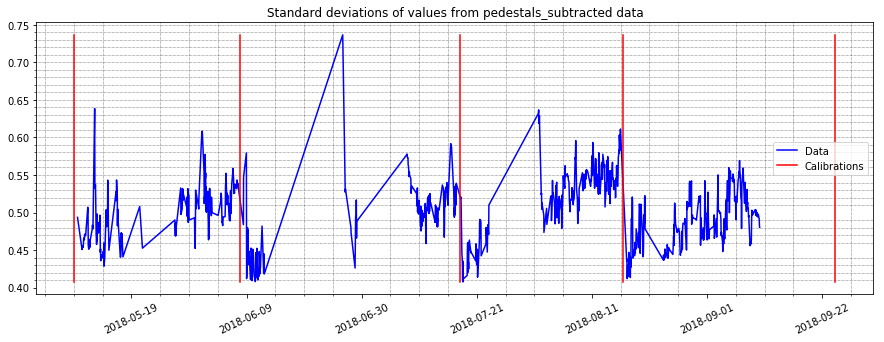

In [4]:
fig, ax = plt.subplots()
ax.set_title('Standard deviations of values from pedestals_subtracted data')
ax.plot(timestamps, stddevs, 'b', label='Data')

for calib_timestamp in calib_timestamps:
    ax.plot([calib_timestamp, calib_timestamp], [min(stddevs), max(stddevs)], 'r', label='Calibrations')

plt.xticks(rotation=25)
plt.rcParams['figure.figsize'] = [15, 5]
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.legend()
plt.show()